In [1]:
import numpy as np
import matplotlib.pyplot as plt
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
%matplotlib inline

In [2]:
# Set up and load in data and simulations...

# Fiducial parameters about which data compression was performed
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Set up the truncated Gaussian prior...

# Prior parameter boundaries
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])

# Prior mean and covariance
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Q = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Import data summaries, simulated data summaries and corresponding parameters, and inverse Fisher matrix...

# NOTE: The compressed summaries should be in the form of pseudo maximum-likelihood parameter estimators
# ie, if you are using the score of an approximate log-likelihood L, you should use compressed summaries
# t = \theta_\mathrm{fiducial} + F^{-1}\nabla L where F is the approximate Fisher matrix

# Compressed data vector
data = np.genfromtxt('simulators/cosmic_shear_nuisances/results_marginalized/compressed_data.dat')

# Parameters at which sims were ran
sim_params = np.genfromtxt('simulators/cosmic_shear_nuisances/results_marginalized/simulations_parameters.dat')

# Compressed data for each simulation (corresponding to parameters above)
sim_data = np.genfromtxt('simulators/cosmic_shear_nuisances/results_marginalized/simulations_data.dat')

# Inverse Fisher matrix: this can be a bit rough, no biggie
Finv = np.genfromtxt('simulators/cosmic_shear_nuisances/results_marginalized/Finv.dat')

In [3]:
# Set up the Delfi object...

# Create the neural density estimator (MAF stands for Masked Autoregressive Flow)
# NOTE: n_inputs = number of parameters, n_outputs = number of compressed summaries
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
DelfiMAF = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_preran/maf")

# Load in the simulations
DelfiMAF.load_simulations(sim_data, sim_params)

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 13.3540, Val_loss: 13.2698
Epoch 00001, Train_loss: 11.6701, Val_loss: 11.6403
Epoch 00002, Train_loss: 10.5055, Val_loss: 10.4820
Epoch 00003, Train_loss: 9.7268, Val_loss: 9.7370
Epoch 00004, Train_loss: 9.5445, Val_loss: 9.5198
Epoch 00005, Train_loss: 8.4133, Val_loss: 8.4230
Epoch 00006, Train_loss: 8.0655, Val_loss: 8.1032
Epoch 00007, Train_loss: 7.2174, Val_loss: 7.2188
Epoch 00008, Train_loss: 6.4657, Val_loss: 6.5128
Epoch 00009, Train_loss: 5.8586, Val_loss: 5.9100
Epoch 00010, Train_loss: 5.2686, Val_loss: 5.3196
Epoch 00011, Train_loss: 4.9409, Val_loss: 4.9926
Epoch 00012, Train_loss: 4.7460, Val_loss: 4.7951
Epoch 00013, Train_loss: 4.7295, Val_loss: 4.7672
Epoch 00014, Train_loss: 4.2617, Val_loss: 4.3049
Epoch 00015, Train_loss: 4.2593, Val_loss: 4.3042
Epoch 00016, Train_loss: 4.1101, Val_loss: 4.1489
Epoch 00017, Train_loss: 4.3663, Val_loss: 4.4232
Epoch 00018, T

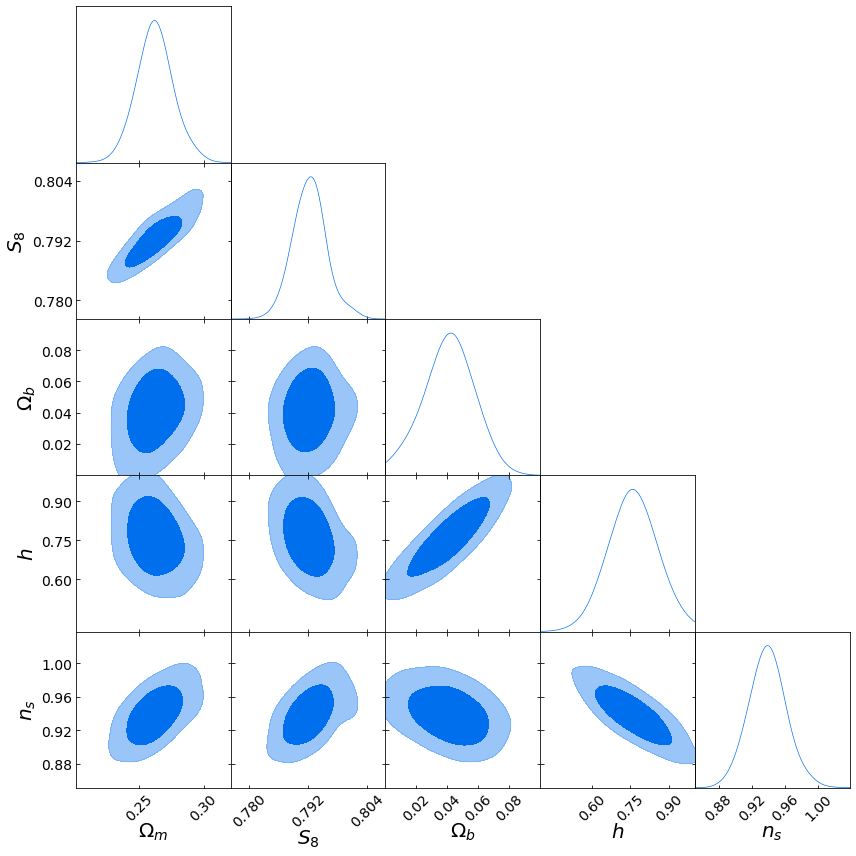

In [4]:
# Do the Fisher pre-training step to inirialize the network
DelfiMAF.fisher_pretraining(50000, prior, epochs=100, patience=10)

Training the neural density estimator...
Epoch 00000, Train_loss: 4.4978, Val_loss: 4.5573
Epoch 00001, Train_loss: 4.2613, Val_loss: 4.3139
Epoch 00002, Train_loss: 4.1496, Val_loss: 4.2282
Epoch 00003, Train_loss: 4.1016, Val_loss: 4.1768
Epoch 00004, Train_loss: 4.0635, Val_loss: 4.0919
Epoch 00005, Train_loss: 4.0371, Val_loss: 4.0813
Epoch 00006, Train_loss: 3.9840, Val_loss: 4.0183
Epoch 00007, Train_loss: 4.0053, Val_loss: 4.0396
Epoch 00008, Train_loss: 3.9749, Val_loss: 3.9849
Epoch 00009, Train_loss: 3.9644, Val_loss: 3.9966
Epoch 00010, Train_loss: 3.9862, Val_loss: 4.0298
Epoch 00011, Train_loss: 3.9441, Val_loss: 3.9856
Epoch 00012, Train_loss: 3.9846, Val_loss: 4.0226
Epoch 00013, Train_loss: 3.9407, Val_loss: 3.9836
Epoch 00014, Train_loss: 3.9533, Val_loss: 3.9981
Epoch 00015, Train_loss: 3.9331, Val_loss: 3.9796
Epoch 00016, Train_loss: 3.9180, Val_loss: 3.9453
Epoch 00017, Train_loss: 3.9208, Val_loss: 3.9397
Epoch 00018, Train_loss: 3.9374, Val_loss: 3.9687
Epoch 000

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_preran/maftmp_model


Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/cosmic_shear/results_preran/mafpost_trained.pdf


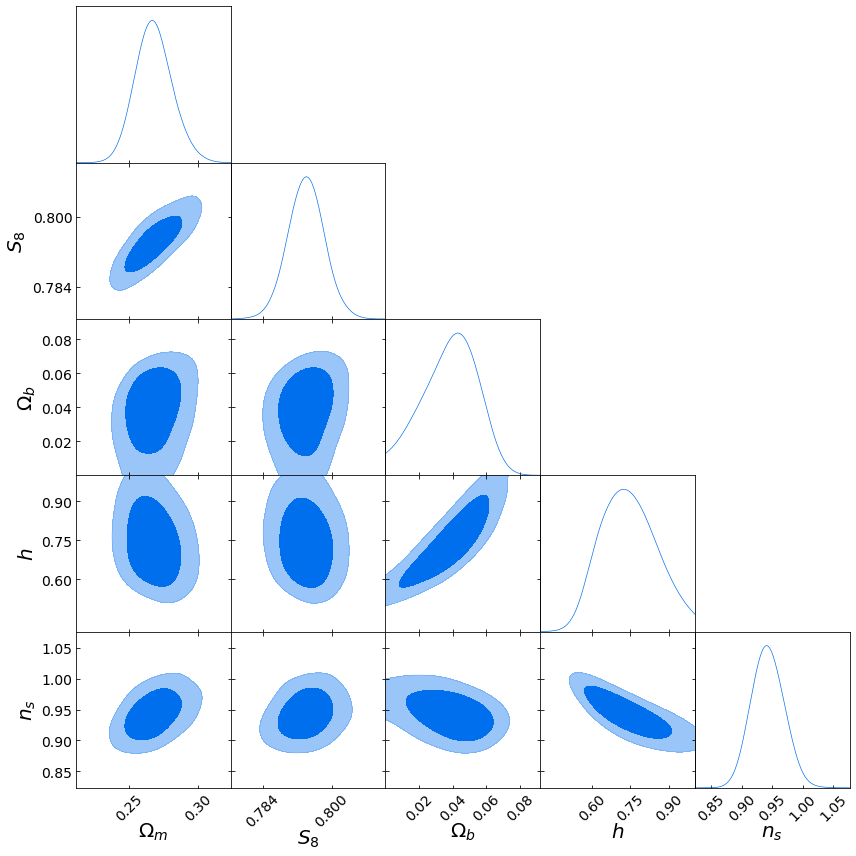

In [5]:
# Train the network
DelfiMAF.train(epochs=100, patience=5, batch_size=100)

In [6]:
# Now let's do the same thing but with a Mixture Density Network instead of a MAF

# Create the neural density estimator (Masked Autoregressive Flow)
# NOTE: n_inputs = number of parameters, n_outputs = number of compressed summaries
# n_components = number of Gaussian components in the MDN (3-5 should be plenty)
MDN = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, 
                                 n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_preran/mdn")

# Load in the simulations
DelfiMDN.load_simulations(sim_data, sim_params)

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 22.5783, Val_loss: 22.5776
Epoch 00001, Train_loss: 14.7943, Val_loss: 14.8915
Epoch 00002, Train_loss: 13.7577, Val_loss: 13.8015
Epoch 00003, Train_loss: 13.3493, Val_loss: 13.4021
Epoch 00004, Train_loss: 12.8285, Val_loss: 12.8509
Epoch 00005, Train_loss: 12.5250, Val_loss: 12.5428
Epoch 00006, Train_loss: 12.1465, Val_loss: 12.2030
Epoch 00007, Train_loss: 11.6934, Val_loss: 11.7117
Epoch 00008, Train_loss: 11.0008, Val_loss: 11.0187
Epoch 00009, Train_loss: 10.5286, Val_loss: 10.5530
Epoch 00010, Train_loss: 10.2024, Val_loss: 10.2239
Epoch 00011, Train_loss: 9.8036, Val_loss: 9.7913
Epoch 00012, Train_loss: 9.2662, Val_loss: 9.2706
Epoch 00013, Train_loss: 9.1802, Val_loss: 9.1953
Epoch 00014, Train_loss: 8.7978, Val_loss: 8.8051
Epoch 00015, Train_loss: 8.4916, Val_loss: 8.4969
Epoch 00016, Train_loss: 8.3042, Val_loss: 8.3085
Epoch 00017, Train_loss: 8.0110, Val_loss: 8.018

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_preran/mdntmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/cosmic_shear/results_preran/mdnfisher_pretrain_post.pdf


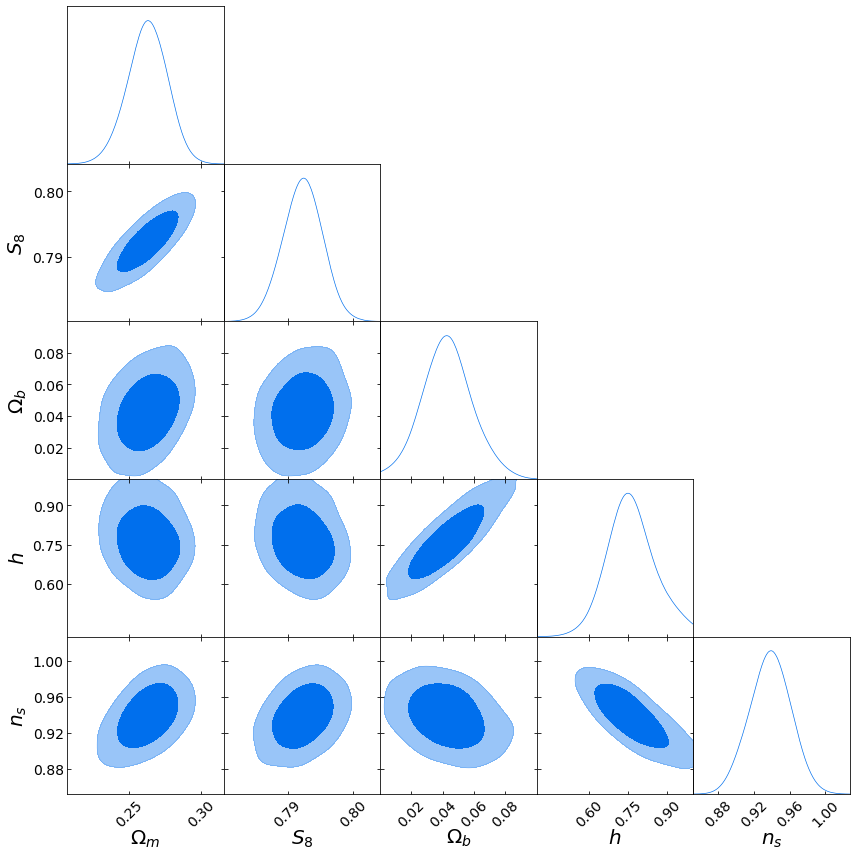

In [7]:
# Do the Fisher pre-training step to inirialize the network
DelfiMDN.fisher_pretraining(50000, prior, epochs=100, patience=10)

Training the neural density estimator...
Epoch 00000, Train_loss: 4.8688, Val_loss: 4.8957
Epoch 00001, Train_loss: 4.5663, Val_loss: 4.6200
Epoch 00002, Train_loss: 4.4058, Val_loss: 4.4806
Epoch 00003, Train_loss: 4.3601, Val_loss: 4.4418
Epoch 00004, Train_loss: 4.3361, Val_loss: 4.4218
Epoch 00005, Train_loss: 4.2079, Val_loss: 4.2820
Epoch 00006, Train_loss: 4.2013, Val_loss: 4.2590
Epoch 00007, Train_loss: 4.1453, Val_loss: 4.2085
Epoch 00008, Train_loss: 4.1881, Val_loss: 4.2727
Epoch 00009, Train_loss: 4.0857, Val_loss: 4.1616
Epoch 00010, Train_loss: 4.0877, Val_loss: 4.1638
Epoch 00011, Train_loss: 4.1005, Val_loss: 4.1762
Epoch 00012, Train_loss: 4.0510, Val_loss: 4.1363
Epoch 00013, Train_loss: 4.0115, Val_loss: 4.0823
Epoch 00014, Train_loss: 4.0245, Val_loss: 4.0940
Epoch 00015, Train_loss: 4.0102, Val_loss: 4.0810
Epoch 00016, Train_loss: 4.0178, Val_loss: 4.1033
Epoch 00017, Train_loss: 4.0486, Val_loss: 4.1302
Epoch 00018, Train_loss: 3.9986, Val_loss: 4.0869
Epoch 000

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_preran/mdntmp_model


Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/cosmic_shear/results_preran/mdnpost_trained.pdf


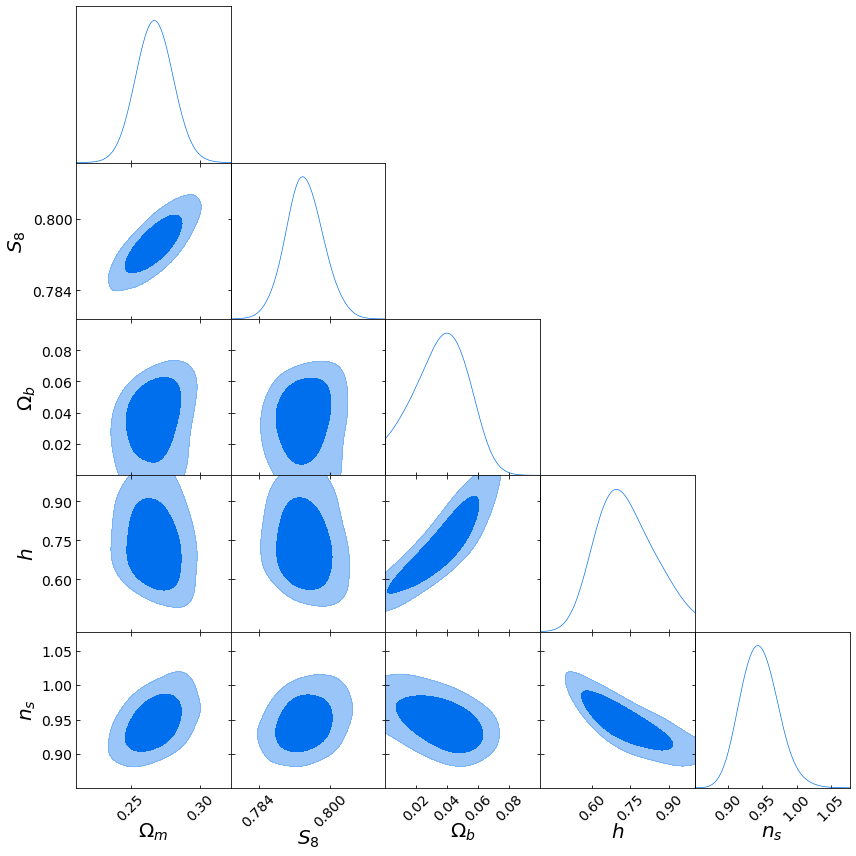

In [8]:
# Train the network
DelfiMDN.train(epochs=100, patience=5, batch_size=100)

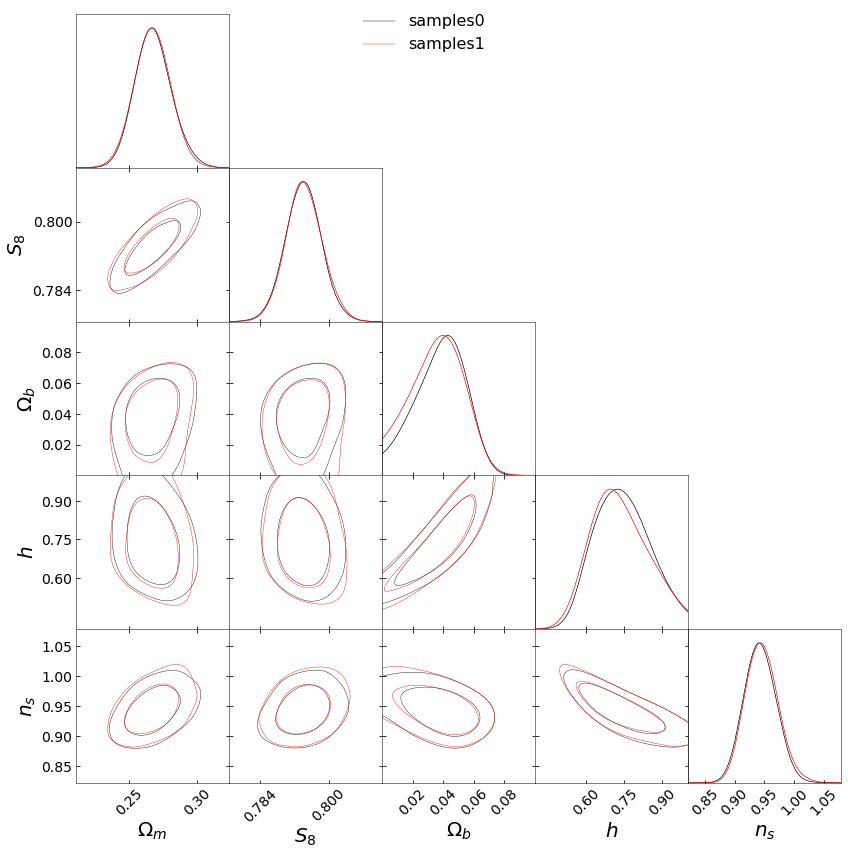

In [12]:
# Let's plot the MAF and MDN posteriors against eachother to check they give the same result

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20

names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
ranges = dict(zip(names, [ [lower[i], upper[i]] for i in range(len(names)) ]))

samples = [DelfiMAF.posterior_samples, DelfiMDN.posterior_samples]
mc_samples = [MCSamples(samples=s, names = names, labels = labels, ranges = ranges) for s in samples]

g.triangle_plot(mc_samples, normalized=True)

for i in range(0, len(names)):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()